In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, matthews_corrcoef, balanced_accuracy_score, f1_score, accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE , ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Load dataset
df = pd.read_csv(r'F:\university\UniVR\Courses\ML\project\data.csv', delimiter=';')
df.rename(columns={'Nacionality': 'Nationality','Daytime/evening attendance\t': 'Daytime/evening attendance'}, inplace=True) 


categorical_cols = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                    "Nationality", "Mother's qualification", "Father's qualification", 
                    "Mother's occupation", "Father's occupation"]

continuous_cols = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Convert categorical features
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Convert binary features
binary_cols = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 
               'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
# for col in binary_cols:
#     df[col] = df[col].astype(bool)

# Ordinal column
ordinal_cols = ['Application order']

#target column
target_col = 'Target'


# Ratio of approved to enrolled curricular units (1st and 2nd semester)
df['approved_enrolled_ratio_1st'] = df['Curricular units 1st sem (approved)'] / (df['Curricular units 1st sem (enrolled)'] + 1e-6)
df['approved_enrolled_ratio_2nd'] = df['Curricular units 2nd sem (approved)'] / (df['Curricular units 2nd sem (enrolled)'] + 1e-6)

# Ratio of evaluations to enrolled units
df['evals_enrolled_ratio_1st'] = df['Curricular units 1st sem (evaluations)'] / (df['Curricular units 1st sem (enrolled)'] + 1e-6)
df['evals_enrolled_ratio_2nd'] = df['Curricular units 2nd sem (evaluations)'] / (df['Curricular units 2nd sem (enrolled)'] + 1e-6)

# Is the student currently enrolled in any curricular units (1st or 2nd sem)?
df['currently_enrolled_1st'] = (df['Curricular units 1st sem (enrolled)'] > 0).astype(int)
df['currently_enrolled_2nd'] = (df['Curricular units 2nd sem (enrolled)'] > 0).astype(int)
df['currently_enrolled_any'] = ((df['Curricular units 1st sem (enrolled)'] > 0) | 
                                (df['Curricular units 2nd sem (enrolled)'] > 0)).astype(int)

# Units enrolled but not yet approved (proxy for "in progress")
df['pending_units_1st'] = df['Curricular units 1st sem (enrolled)'] - df['Curricular units 1st sem (approved)']
df['pending_units_2nd'] = df['Curricular units 2nd sem (enrolled)'] - df['Curricular units 2nd sem (approved)']
df['pending_units_total'] = df['pending_units_1st'] + df['pending_units_2nd']



df['is_debtor'] = df['Debtor'].astype(int)
df['fees_up_to_date'] = df['Tuition fees up to date'].astype(int)



# # Improvement or decline in grades between semesters
# df['grade_improvement'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']

# # Total approved units across both semesters
# df['total_approved_units'] = df['Curricular units 1st sem (approved)'] + df['Curricular units 2nd sem (approved)']

# # Mean grade across both semesters
# df['mean_sem_grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# # Total number of evaluations
# df['total_evaluations'] = df['Curricular units 1st sem (evaluations)'] + df['Curricular units 2nd sem (evaluations)']

# Whether the student had any semester with zero approved units (potential dropout risk)
df['zero_approved_1st'] = (df['Curricular units 1st sem (approved)'] == 0).astype(int)
df['zero_approved_2nd'] = (df['Curricular units 2nd sem (approved)'] == 0).astype(int)
df['any_zero_approved'] = ((df['zero_approved_1st'] == 1) | (df['zero_approved_2nd'] == 1)).astype(int)

# Whether the student had any semester with zero evaluations (potential disengagement)
df['zero_evals_1st'] = (df['Curricular units 1st sem (evaluations)'] == 0).astype(int)
df['zero_evals_2nd'] = (df['Curricular units 2nd sem (evaluations)'] == 0).astype(int)
df['any_zero_evals'] = ((df['zero_evals_1st'] == 1) | (df['zero_evals_2nd'] == 1)).astype(int)

# Interaction between age and admission grade (older students with high/low grades)
df['age_admission_interaction'] = df['Age at enrollment'] * df['Admission grade']





# # Economic context at enrollment
# df['gdp_unemp_interaction'] = df['GDP'] * df['Unemployment rate']
# df['gdp_inflation_interaction'] = df['GDP'] * df['Inflation rate']

# # High application order (late choice) indicator
# df['late_application'] = (df['Application order'] > df['Application order'].median()).astype(int)

# # Was this course their first choice?
# df['first_choice'] = (df['Application order'] == 1).astype(int)

# # Highest parental qualification
# df['highest_parent_qualification'] = df[['Mother\'s qualification', 'Father\'s qualification']].max(axis=1)

# Highest parental occupation
df['highest_parent_occupation'] = df[['Mother\'s occupation', 'Father\'s occupation']].max(axis=1)

df.drop(columns=[   
                'Father\'s occupation', 'Mother\'s occupation'], inplace=True)

# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# df['Application order'] = ordinal_encoder.fit_transform(df[['Application order']])


In [3]:


from xgboost import XGBClassifier

f1-score: 0.7706214689265537


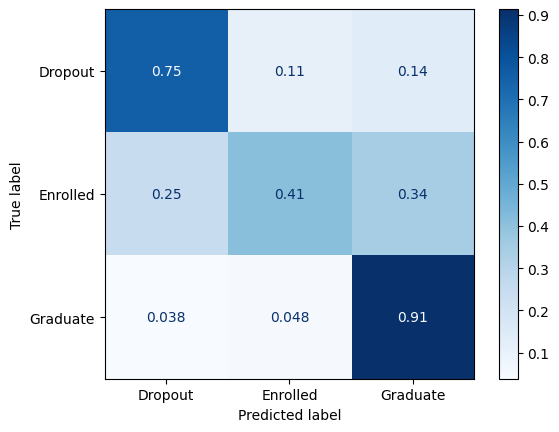

In [8]:


X = df.drop(columns=[target_col])
# # Convert categorical columns to integer codes for XGBoost compatibility
# for col in X.select_dtypes(include='category').columns:
#     X[col] = X[col].cat.codes

y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)    

pipeline = Pipeline([
    ('clf',  XGBClassifier(random_state=42, enable_categorical=True)) ])  

# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train0, y_train0)
pipeline.fit(X_train0, y_train0)
y_pred = pipeline.predict(X_test)

print(f'f1-score: {f1_score(y_test, y_pred, average="micro")}')

cm= confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

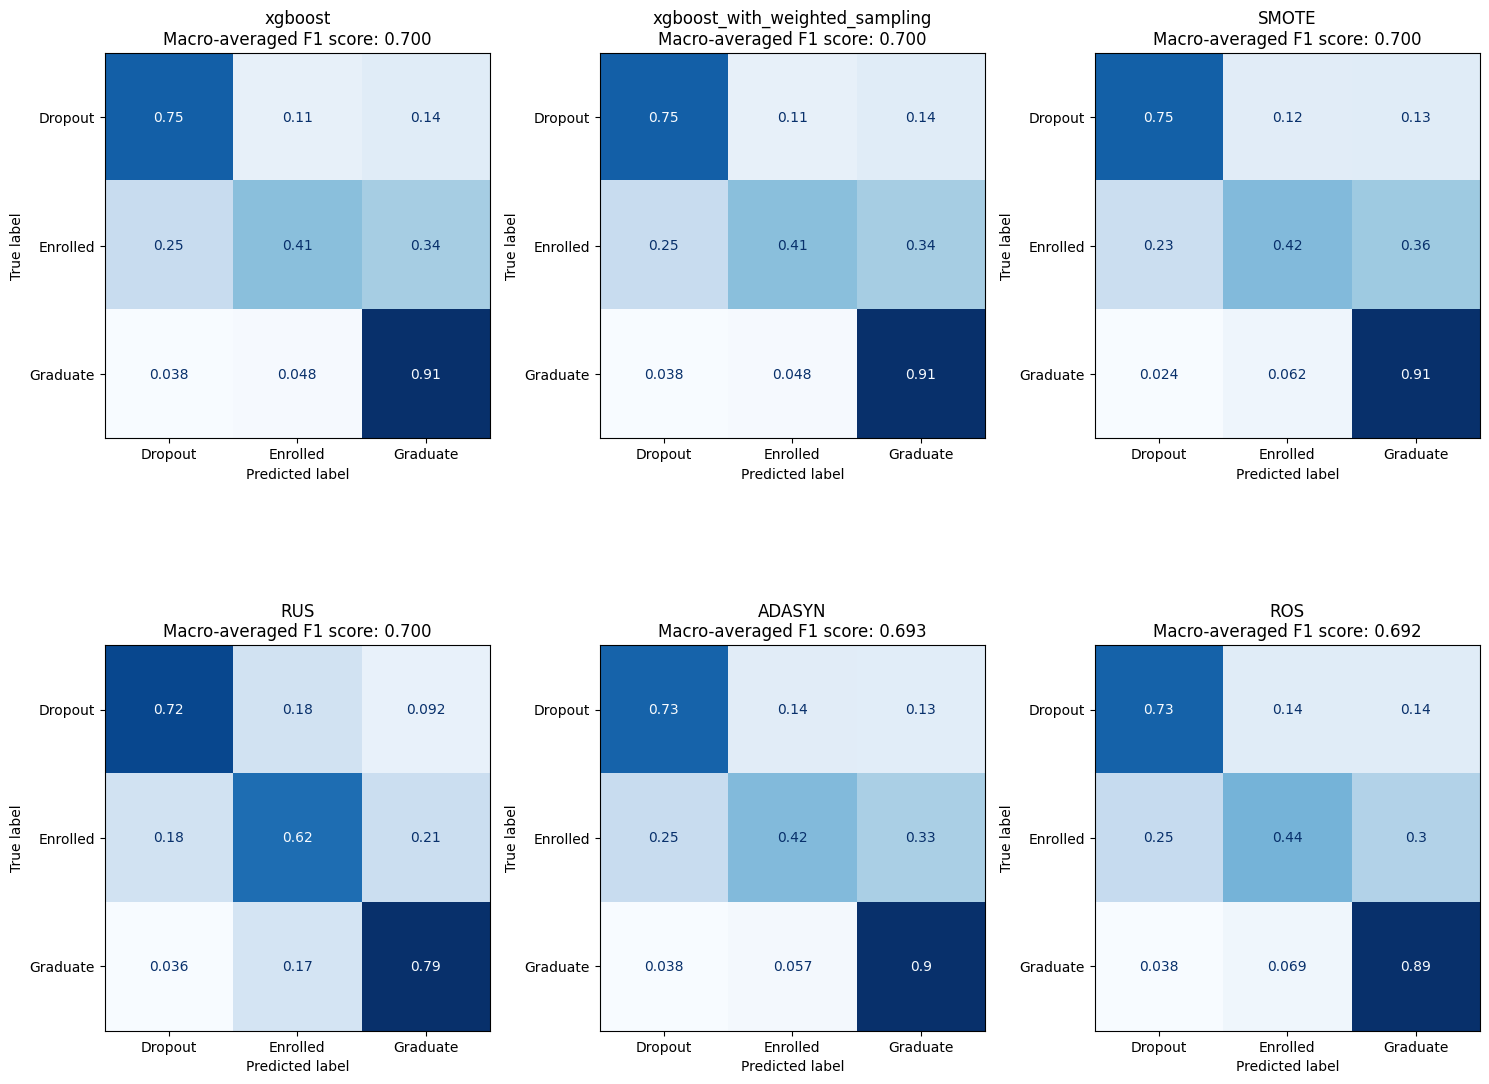

In [9]:
Model_names = ['xgboost', 'xgboost_with_weighted_sampling', 'SMOTE', 'ROS', 'RUS', 'ADASYN']
all_results = []
X = df.drop(columns=[target_col])
# # Convert categorical columns to integer codes for XGBoost compatibility
# for col in X.select_dtypes(include='category').columns:
#     X[col] = X[col].cat.codes

y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)    

    
pipeline = Pipeline([
        # ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42, enable_categorical=True))])  

for model in Model_names:
    pipeline = Pipeline([
        # ('preprocess', preprocessor),
        ('clf', XGBClassifier(random_state=42, enable_categorical=True))])  

    if model == 'xgboost':
        X_train = X_train0
        y_train = y_train0
    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)

    # if model == 'xgboost_with_weighted_sampling':
    #     sample_weights = compute_sample_weight(class_weight="balanced", y=y_train0)
    #     pipeline.fit(X_train0, y_train0, clf__sample_weight=sample_weights)
    #     y_pred = pipeline.predict(X_test)
    # else:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    all_results.append({
        "type": model,
        "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
        "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
    })
    
n_models = len(all_results)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results = pd.DataFrame(all_results).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results.iterrows():
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

In [5]:
for model in Model_names:
    pipeline = Pipeline([
        ('clf', XGBClassifier(random_state=42, enable_categorical=True))
    ])
    
    if model == 'xgboost':
        X_train, y_train = X_train0, y_train0
        pipeline.fit(X_train, y_train)
    elif model == 'xgboost_with_weighted_sampling':
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train0)
        pipeline.fit(X_train0, y_train0, clf__sample_weight=sample_weights)
    else:
        # For resampling models
        if model == 'SMOTE':
            sampler = SMOTE(random_state=42)
        elif model == 'ROS':
            sampler = RandomOverSampler(random_state=42)
        elif model == 'RUS':
            sampler = RandomUnderSampler(random_state=42)
        elif model == 'ADASYN':
            sampler = ADASYN(random_state=42)
        else:
            raise ValueError("Unknown model")

        X_train, y_train = sampler.fit_resample(X_train0, y_train0)
        pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print(f"Model: {model}, macro F1: {score:.4f}")

Model: xgboost, macro F1: 0.7004
Model: xgboost_with_weighted_sampling, macro F1: 0.7040
Model: SMOTE, macro F1: 0.7001
Model: ROS, macro F1: 0.6922
Model: RUS, macro F1: 0.6996
Model: ADASYN, macro F1: 0.6928


In [4]:
from imblearn.pipeline import Pipeline as ImbPipeline

f1-score: 0.7004275203624323


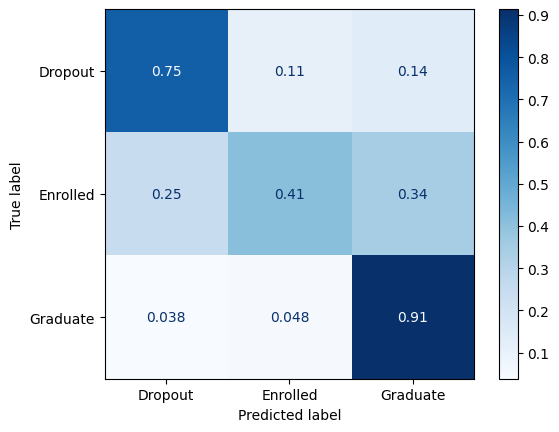

In [11]:

X = df.drop(columns=[target_col])

y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)    

resamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ROS': RandomOverSampler(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RUS':RandomUnderSampler(random_state=42),
    'xgboost': None  # No resampling for XGBoost, it will handle imbalance internally
}

all_results_grid = []


pipeline0 = ImbPipeline([
    ('clf',  XGBClassifier(random_state=42, enable_categorical=True)) ])  
pipeline0.fit(X_train0, y_train0)
y_pred = pipeline0.predict(X_test)

print(f'f1-score: {f1_score(y_test, y_pred, average="macro")}')

cm= confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

for model_name, sampler in resamplers.items():
    pipeline = ImbPipeline([
        ('sampler', sampler),
     ('clf', XGBClassifier(random_state=42, enable_categorical=True))
    ])

    pipeline.fit(X_train0, y_train0)
    y_pred = pipeline.predict(X_test)

    all_results_grid.append({
        "type": model_name,
        "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
        "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
    })


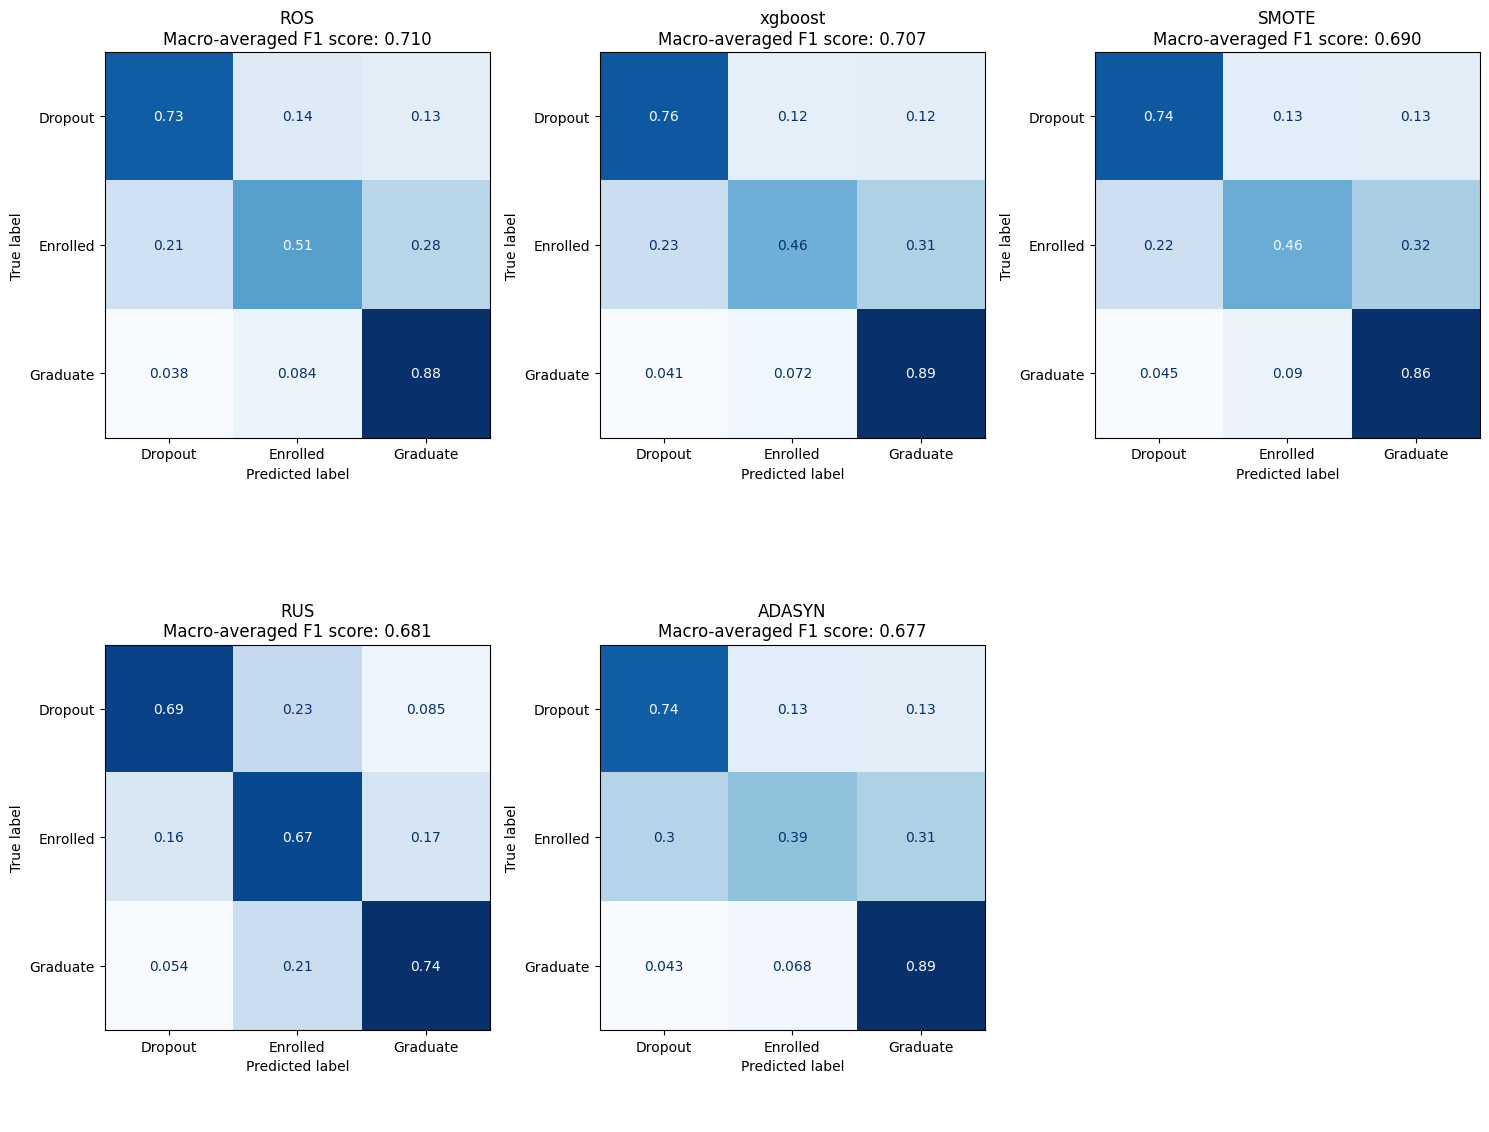

In [6]:

n_models = len(all_results_grid)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))
df_results_grid = pd.DataFrame(all_results_grid).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)
fig_grid, axes_grid = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes_grid = axes_grid.flatten()
for idx, result in df_results_grid.iterrows():
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes_grid[idx], colorbar=False, cmap='Blues')
    axes_grid[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')


for idx in range(n_models, len(axes_grid)):
    axes_grid[idx].axis('off')

plt.tight_layout()

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline


Class Imbalance DataFrame:
           Count  Proportion
Target                     
Graduate   2209    0.499322
Dropout    1421    0.321203
Enrolled    794    0.179476

Imbalance ratio (max/min): 2.78


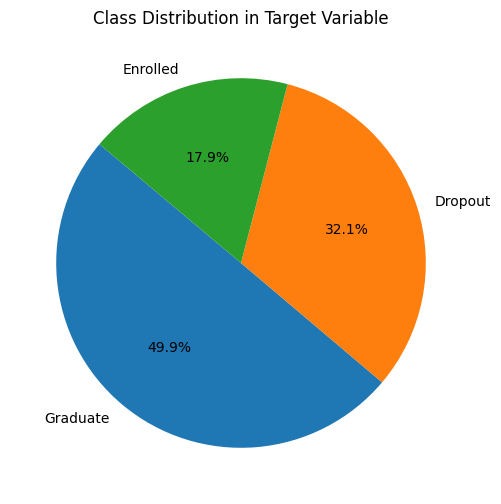

In [3]:
# Calculate imbalance ratio -- ratio of most common to least common
class_counts = df['Target'].value_counts()
class_proportions = df['Target'].value_counts(normalize=True)

class_im_df = pd.concat([class_counts, class_proportions], axis=1)
class_im_df.columns = ['Count', 'Proportion']
print("\nClass Imbalance DataFrame:\n", class_im_df)

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Target Variable')  
plt.show()

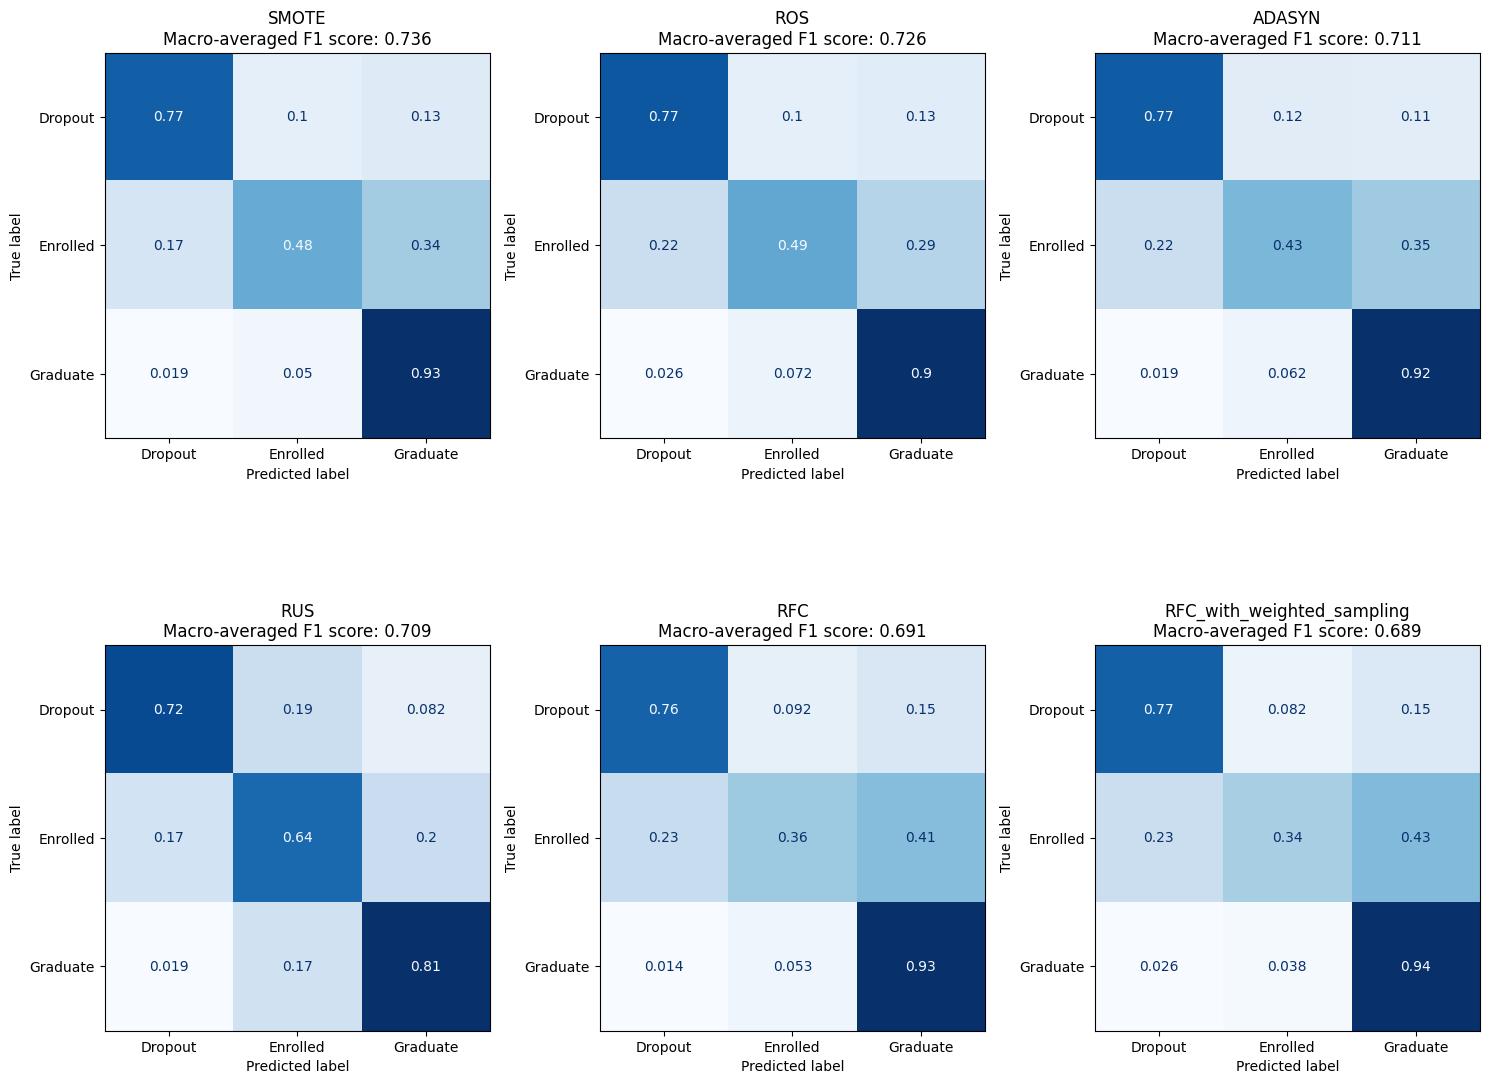

In [35]:
# Prepare data for modeling       
X = df.drop(columns=[target_col])
y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Model_names = ['RFC', 'RFC_with_weighted_sampling', 'SMOTE', 'ROS', 'RUS', 'ADASYN']

all_results = []

# # Set up column transformer for encoding
# preprocessor = ColumnTransformer(
#     transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#     remainder='passthrough')

# Build pipeline
pipeline = Pipeline([
        # ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))])  

for model in Model_names:
    if model == 'RFC':
        X_train = X_train0
        y_train = y_train0

    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
        

    if  model == 'RFC_with_weighted_sampling':
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train0)
        pipeline.fit(X_train0, y_train0, clf__sample_weight=sample_weights)
        y_pred = pipeline.predict(X_test) 
    else:  
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
    # Store results
    all_results.append({
           "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
        })

n_models = len(all_results)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results = pd.DataFrame(all_results).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results.iterrows():    
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

    
# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [32]:
df_results[["type", "macro_averaged_F1_score"]]

,type,macro_averaged_F1_score
0,ADASYN,0.624429
1,ROS,0.624211
2,SMOTE,0.616929
3,RUS,0.606280
4,RFC,0.602376
5,RFC_with_weighted_sampling,0.582487


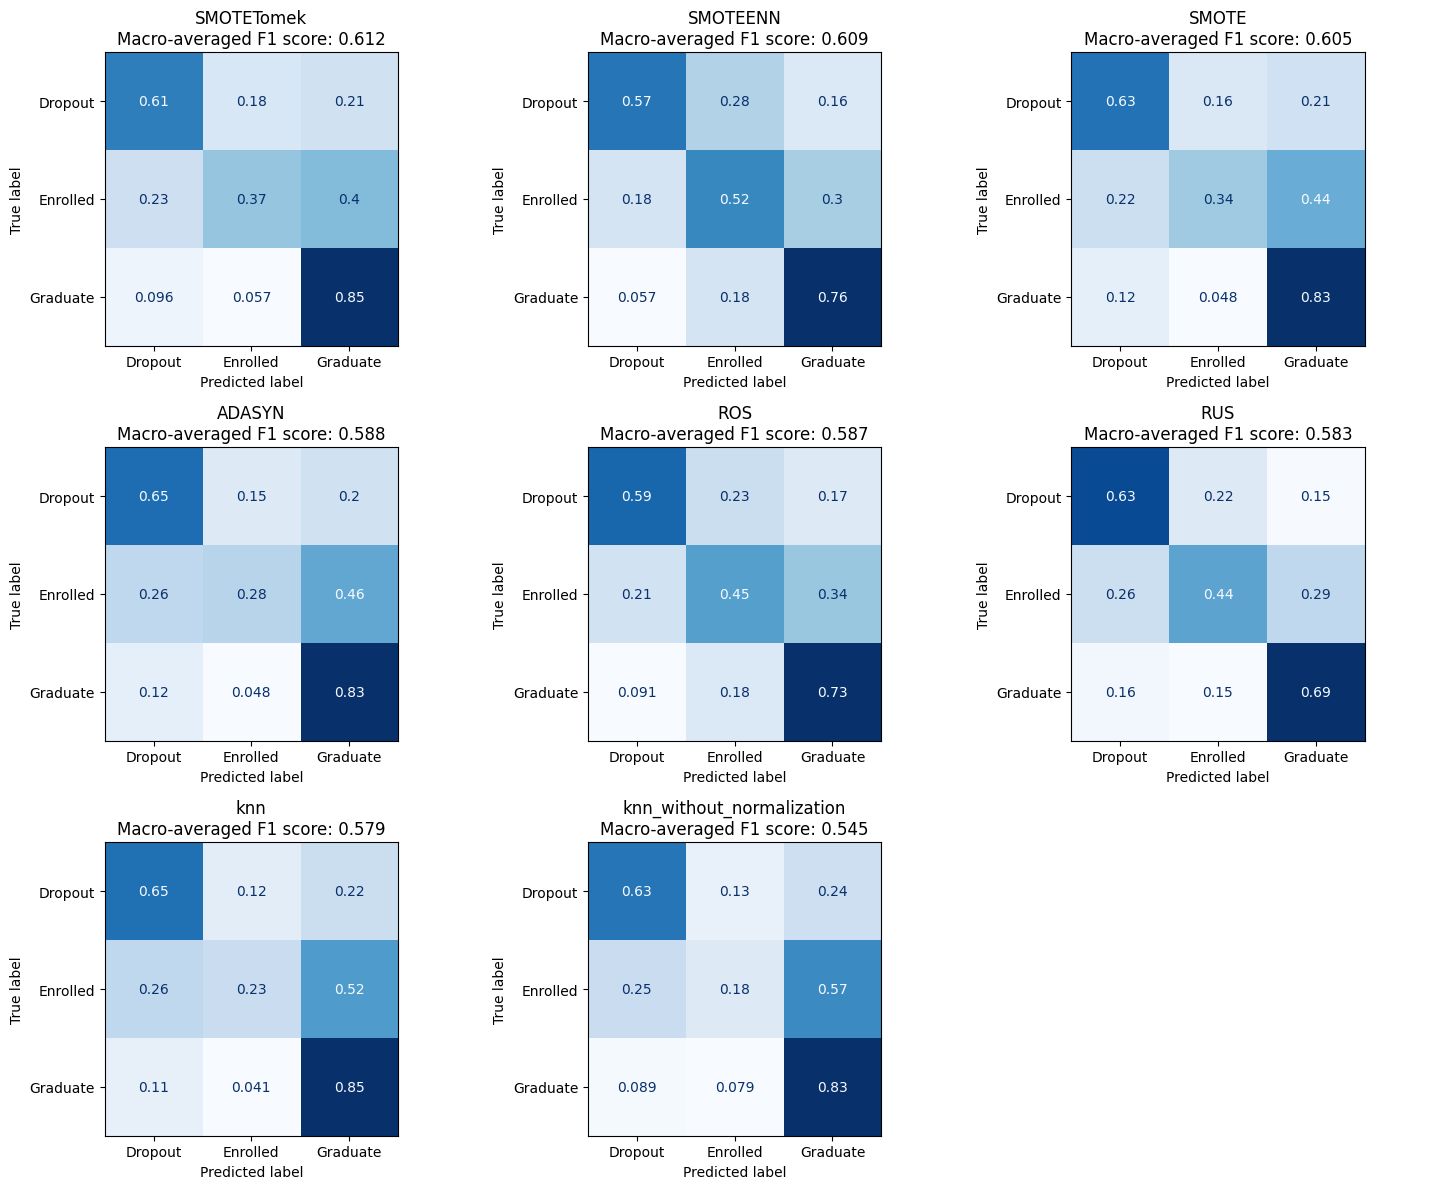

In [ ]:
# KNN Classifier with different sampling methods
all_results_knn=[]

###
preprocessor_knn = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough')

pipeline_knn = Pipeline([
    ('preprocess', preprocessor_knn),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

pipeline_knn.fit(X_train0, y_train0)
y_pred = pipeline_knn.predict(X_test)

all_results_knn.append({
            "type": "knn_without_normalization",
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
            })
###

preprocessor_knn = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('cont', StandardScaler(), continuous_cols + ordinal_cols)],
    remainder='passthrough')


pipeline_knn = Pipeline([
    ('preprocess', preprocessor_knn),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

Model_names_knn = ['knn', 'SMOTE', 'ROS', 'RUS', 'ADASYN', 'SMOTETomek', 'SMOTEENN']
for model in Model_names_knn:
    if model == 'knn':
        X_train = X_train0
        y_train = y_train0
    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
    elif model == 'SMOTETomek': 
        smotetomek = SMOTETomek( random_state=42)
        X_train, y_train = smotetomek.fit_resample(X_train0, y_train0)
    elif model == 'SMOTEENN':
        smoteenn = SMOTEENN( random_state=42)
        X_train, y_train = smoteenn.fit_resample(X_train0, y_train0)

    pipeline_knn.fit(X_train, y_train)
    y_pred = pipeline_knn.predict(X_test)
    
    # Store results
    all_results_knn.append({
            "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
            })


n_models = len(all_results_knn)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results_knn = pd.DataFrame(all_results_knn).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results_knn.iterrows():
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

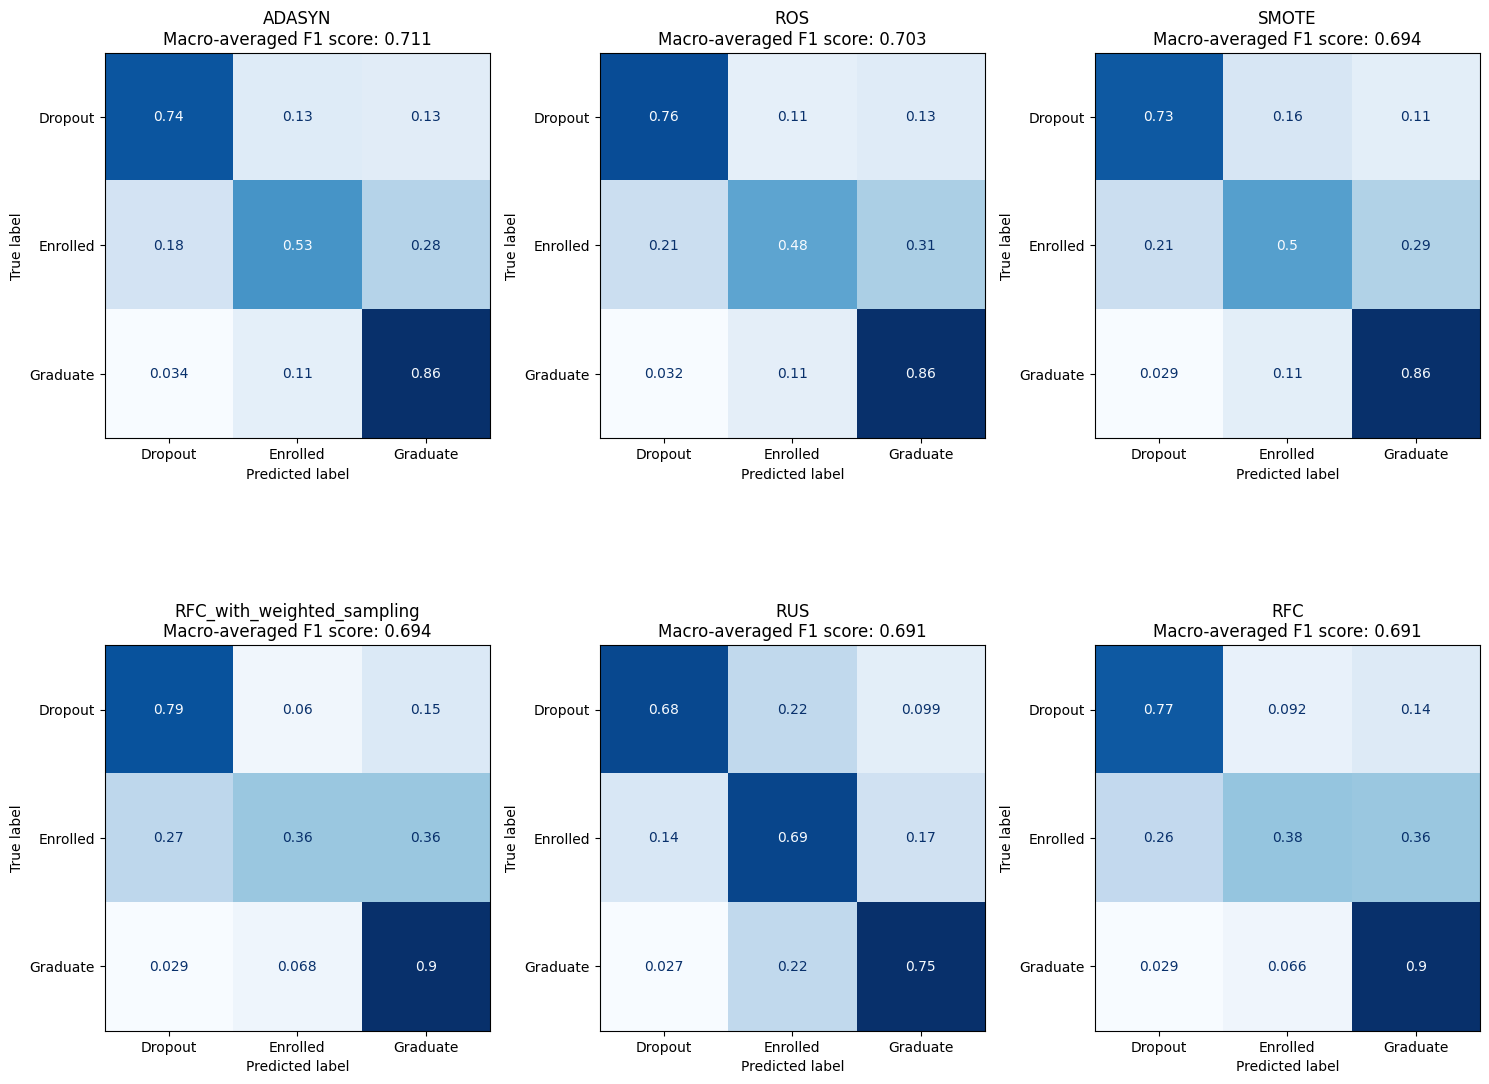

In [ ]:
#Testing classification without considering categorical features
categorical_cols = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                    "Nationality", "Mother's qualification", "Father's qualification"]
X = df.drop(columns=[target_col]+ categorical_cols)
#X = df[importance_df.sort_values('importance', ascending=False).head(10).feature]
y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


Model_names = ['RFC', 'RFC_with_weighted_sampling', 'SMOTE', 'ROS', 'RUS', 'ADASYN']

all_results = []

# # Set up column transformer for encoding
# preprocessor = ColumnTransformer(
#     transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#     remainder='passthrough')

# Build pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))])  


for model in Model_names:
    if model == 'RFC':
        X_train = X_train0
        y_train = y_train0

    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
        
    if  model == 'RFC_with_weighted_sampling':
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train0)
        pipeline.fit(X_train0, y_train0, clf__sample_weight=sample_weights)
        y_pred = pipeline.predict(X_test) 
    else:  
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
    # Store results
    all_results.append({
           "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
        })
n_models = len(all_results)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results = pd.DataFrame(all_results).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results.iterrows():    
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

    
# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

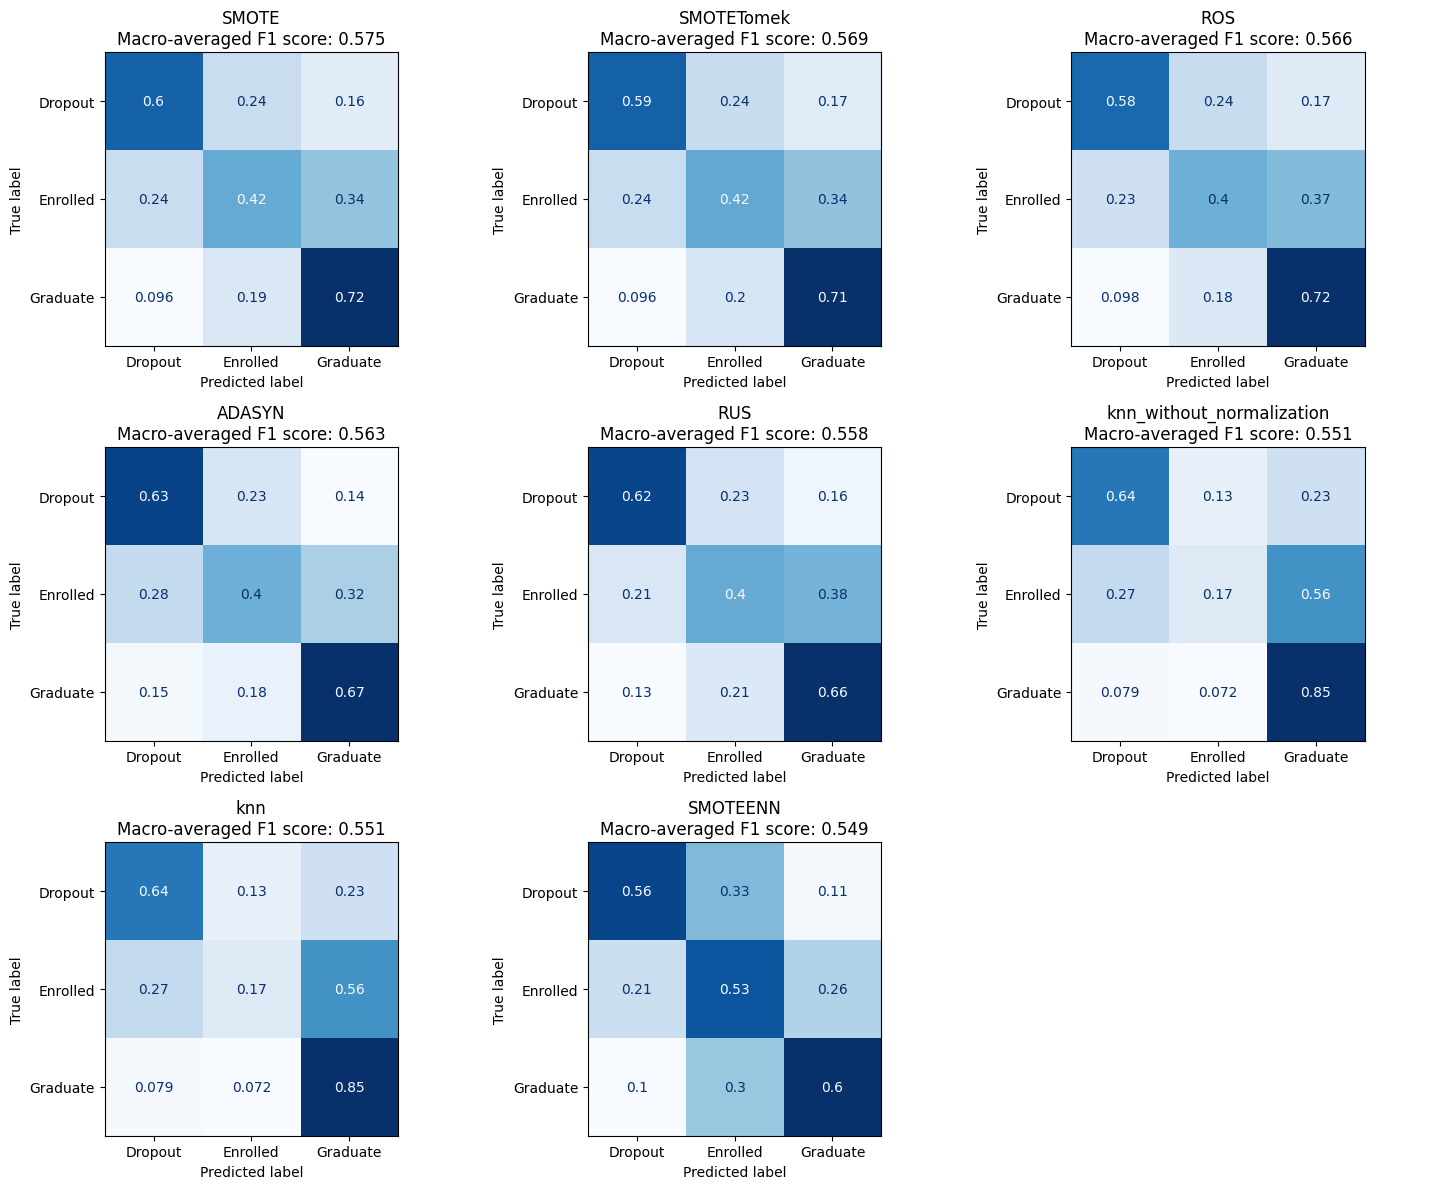

In [ ]:
# KNN Classifier with different sampling methods without categorical features
X = df.drop(columns=[target_col]+ categorical_cols)
all_results_knn=[]

###
pipeline_knn = Pipeline([
    ('clf', KNeighborsClassifier(n_neighbors=3))])

pipeline_knn.fit(X_train0, y_train0)
y_pred = pipeline_knn.predict(X_test)

all_results_knn.append({
            "type": "knn_without_normalization",
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
            })
###

preprocessor_knn = ColumnTransformer(
    transformers=[('cont', StandardScaler(), continuous_cols + ordinal_cols)],
    remainder='passthrough')


pipeline_knn = Pipeline([
    ('clf', KNeighborsClassifier(n_neighbors=3))])

Model_names_knn = ['knn', 'SMOTE', 'ROS', 'RUS', 'ADASYN', 'SMOTETomek', 'SMOTEENN']
for model in Model_names_knn:
    if model == 'knn':
        X_train = X_train0
        y_train = y_train0
    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
    elif model == 'SMOTETomek': 
        smotetomek = SMOTETomek( random_state=42)
        X_train, y_train = smotetomek.fit_resample(X_train0, y_train0)
    elif model == 'SMOTEENN':
        smoteenn = SMOTEENN( random_state=42)
        X_train, y_train = smoteenn.fit_resample(X_train0, y_train0)

    pipeline_knn.fit(X_train, y_train)
    y_pred = pipeline_knn.predict(X_test)
    
    # Store results
    all_results_knn.append({
            "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
            })


n_models = len(all_results_knn)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results_knn = pd.DataFrame(all_results_knn).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results_knn.iterrows():
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

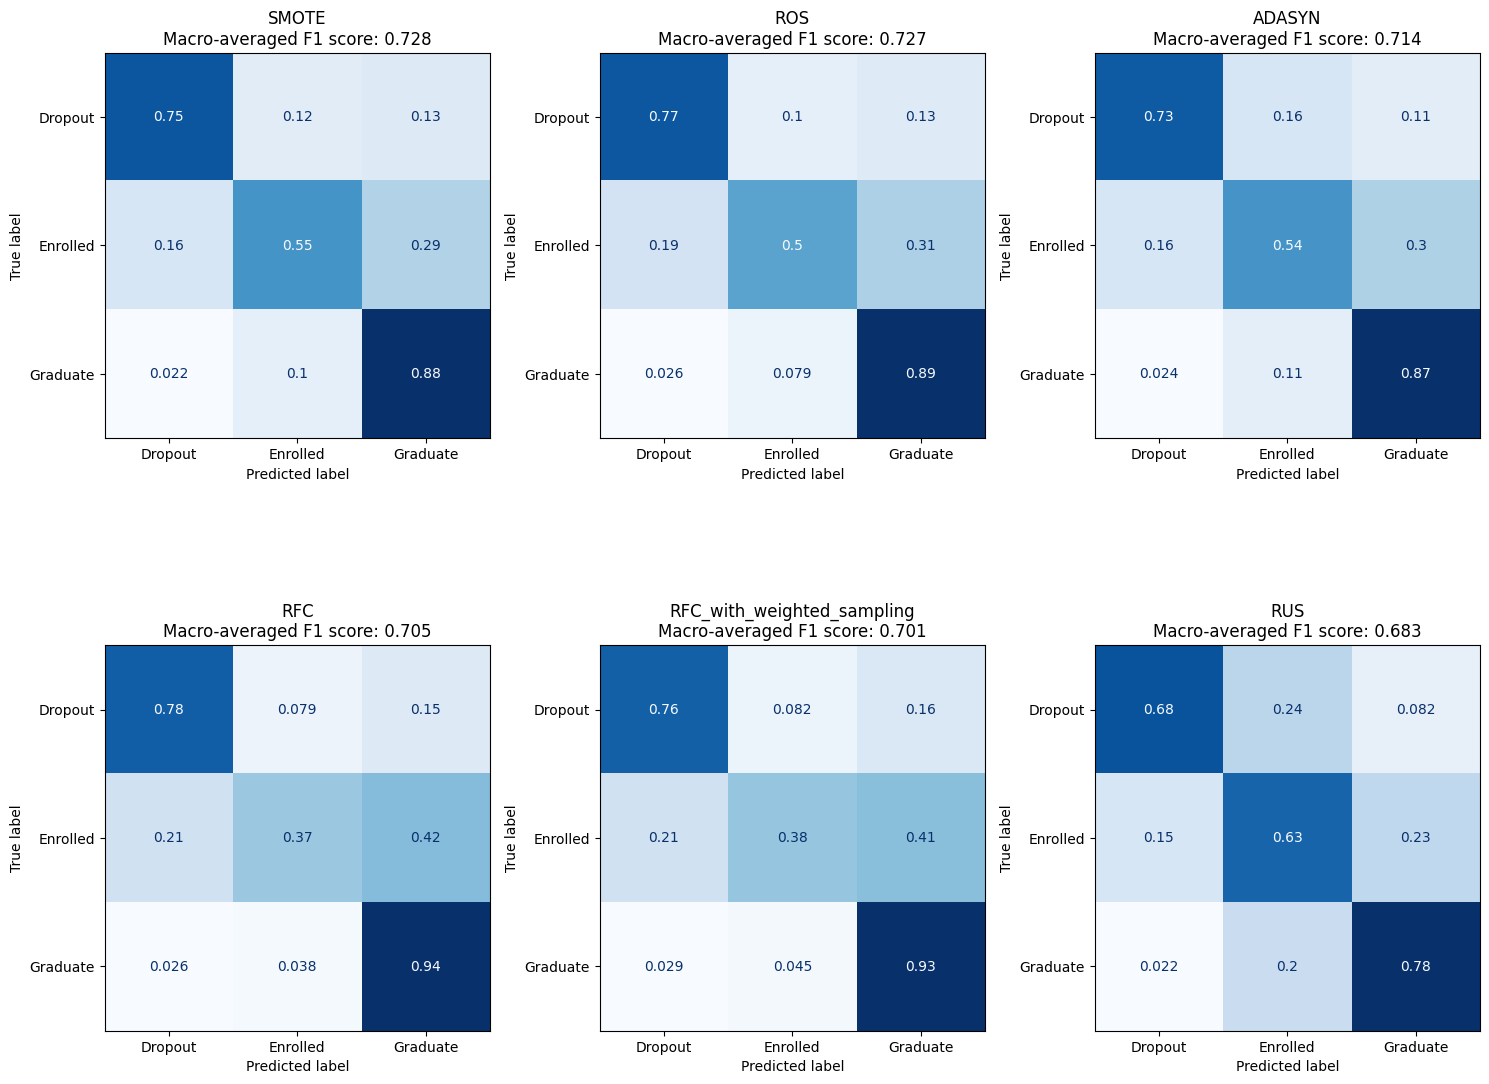

In [42]:
#Testing classification without considering categorical features
categorical_cols = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                    "Nationality", "Mother's qualification", "Father's qualification"]
X = df.drop(columns=[target_col]+ categorical_cols)
y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


Model_names = ['RFC', 'RFC_with_weighted_sampling', 'SMOTE', 'ROS', 'RUS', 'ADASYN']

all_results = []

# # Set up column transformer for encoding
# preprocessor = ColumnTransformer(
#     transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#     remainder='passthrough')

# Build pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))])  


for model in Model_names:
    if model == 'RFC':
        X_train = X_train0
        y_train = y_train0

    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
        
    if  model == 'RFC_with_weighted_sampling':
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train0)
        pipeline.fit(X_train0, y_train0, clf__sample_weight=sample_weights)
        y_pred = pipeline.predict(X_test) 
    else:  
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
    # Store results
    all_results.append({
           "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
        })
n_models = len(all_results)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results = pd.DataFrame(all_results).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results.iterrows():    
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

    
# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [43]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train0, y_train0)
pipeline.fit(X_resampled, y_resampled)
y_pred = pipeline.predict(X_test)
print("SMOTEENN Macro F1:", f1_score(y_test, y_pred, average='macro'))

SMOTEENN Macro F1: 0.6884835182707523


In [50]:
importances = pipeline.named_steps['clf'].feature_importances_
feature_names = X_train0.columns if hasattr(X_train0, 'columns') else [f'feature_{i}' for i in range(len(importances))]


importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(importance_df.sort_values('importance', ascending=False).head(10).feature)

28               approved_enrolled_ratio_2nd
27               approved_enrolled_ratio_1st
21       Curricular units 2nd sem (approved)
22          Curricular units 2nd sem (grade)
3                            Admission grade
2             Previous qualification (grade)
16          Curricular units 1st sem (grade)
15       Curricular units 1st sem (approved)
10                         Age at enrollment
20    Curricular units 2nd sem (evaluations)
Name: feature, dtype: object


In [49]:
feature_names

Index(['Application order', 'Daytime/evening attendance',
       'Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'approved_enrolled_ratio_1st',
       'approved_enrolled_ratio_2nd'],
      dtype='object')

In [55]:
import shap

explainer = shap.TreeExplainer(pipeline.named_steps['clf'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df[importance_df.sort_values('importance', ascending=False).head(10).feature].tolist(), plot_type="bar")

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [47]:
#Testing classification without considering categorical features
categorical_cols = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                    "Nationality", "Mother's qualification", "Father's qualification"]
X = df.drop(columns=[target_col]+ categorical_cols)
#X = df[importance_df.sort_values('importance', ascending=False).head(10).feature]
y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))])  

#ADASYN
adasyn = ADASYN(random_state=42)
X_train_ada, y_train_ada = adasyn.fit_resample(X_train0, y_train0)

#SMOTE  
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train0, y_train0)

#smotetomek
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train0, y_train0)

#svmsmote
from imblearn.over_sampling import SVMSMOTE
svm_smote = SVMSMOTE(random_state=42)
X_train_svm_smote, y_train_svm_smote = svm_smote.fit_resample(X_train0, y_train0)





In [48]:
pipeline.fit(X_train_ada, y_train_ada)
y_pred_ada = pipeline.predict(X_test)
print("ADASYN Macro F1:", f1_score(y_test, y_pred_ada, average='macro'))

pipeline.fit(X_train_smote, y_train_smote)
y_pred_smote = pipeline.predict(X_test) 

print("SMOTE Macro F1:", f1_score(y_test, y_pred_smote, average='macro'))

pipeline.fit(X_train_smotetomek, y_train_smotetomek)    
y_pred_smotetomek = pipeline.predict(X_test)
print("SMOTETomek Macro F1:", f1_score(y_test, y_pred_smotetomek, average='macro'))

pipeline.fit(X_train_svm_smote, y_train_svm_smote)
y_pred_svm_smote = pipeline.predict(X_test)
print("SVMSMOTE Macro F1:", f1_score(y_test, y_pred_svm_smote, average='macro'))


ADASYN Macro F1: 0.713752446228146
SMOTE Macro F1: 0.7283108315669975
SMOTETomek Macro F1: 0.7147994325513092
SVMSMOTE Macro F1: 0.7018960889454237


In [60]:
importances = pipeline.named_steps['clf'].feature_importances_
feature_names = X_train0.columns if hasattr(X_train0, 'columns') else [f'feature_{i}' for i in range(len(importances))]


importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(importance_df.sort_values('importance', ascending=False).head(10))

                                feature  importance
28          approved_enrolled_ratio_2nd    0.122901
27          approved_enrolled_ratio_1st    0.083968
21  Curricular units 2nd sem (approved)    0.073035
22     Curricular units 2nd sem (grade)    0.054572
15  Curricular units 1st sem (approved)    0.046810
30             evals_enrolled_ratio_2nd    0.044799
7               Tuition fees up to date    0.042636
37            age_admission_interaction    0.041916
16     Curricular units 1st sem (grade)    0.041663
3                       Admission grade    0.038165


In [62]:
importances = pipeline.named_steps['clf'].feature_importances_
feature_names = X_train0.columns if hasattr(X_train0, 'columns') else [f'feature_{i}' for i in range(len(importances))]


importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(importance_df.sort_values('importance', ascending=False).head(10))

                                feature  importance
28          approved_enrolled_ratio_2nd    0.126528
27          approved_enrolled_ratio_1st    0.084006
21  Curricular units 2nd sem (approved)    0.068765
22     Curricular units 2nd sem (grade)    0.063490
30             evals_enrolled_ratio_2nd    0.043629
7               Tuition fees up to date    0.042218
37            age_admission_interaction    0.042093
15  Curricular units 1st sem (approved)    0.042063
16     Curricular units 1st sem (grade)    0.040405
29             evals_enrolled_ratio_1st    0.037587


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_ada, y_train_ada)

C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__min_samples_split': [1, 2, 5, 10],
                         'clf__n_estimators': [100, 200, 300, 400]},
             scoring='f1_macro')

In [61]:
print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)

Best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best macro F1: 0.7928596320168212


In [63]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)


print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)


Best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best macro F1: 0.8133873601666932


In [67]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_smotetomek, y_train_smotetomek)


print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)

C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

Best parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best macro F1: 0.8216950105741082


In [68]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_svm_smote, y_train_svm_smote)


print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)

C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

Best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best macro F1: 0.821239876350484


In [69]:
from sklearn.model_selection import cross_val_score
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, max_depth=None, min_samples_split=2, n_estimators=200))
])
y_pred_ada = pipeline.fit(X_train_ada, y_train_ada)

scores = cross_val_score(pipeline, X_train_ada, y_train_ada, cv=5, scoring='f1_macro')
print("Cross-validated Macro F1:", scores)
print("Mean Macro F1:", scores.mean())

Cross-validated Macro F1: [0.73458833 0.75321511 0.83155062 0.8370021  0.80794201]
Mean Macro F1: 0.7928596320168212


In [25]:
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42,max_depth= None, min_samples_split= 2, n_estimators= 300))
])

y_pred_smote = pipeline.fit(X_train_smote, y_train_smote)
scores = cross_val_score(pipeline, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print("Cross-validated Macro F1:", scores)
print("Mean Macro F1:", scores.mean())

Cross-validated Macro F1: [0.74176651 0.77250198 0.8438673  0.87390826 0.86552935]
Mean Macro F1: 0.8195146802498166


In [ ]:
y_pred_ada_labels = y_pred_ada.predict(X_test)
print(classification_report(y_test, y_pred_ada_labels, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred_ada_labels))

              precision    recall  f1-score   support

     Dropout       0.88      0.74      0.80       316
    Enrolled       0.47      0.53      0.50       151
    Graduate       0.82      0.87      0.84       418

    accuracy                           0.77       885
   macro avg       0.72      0.71      0.71       885
weighted avg       0.78      0.77      0.77       885

[[234  47  35]
 [ 24  80  47]
 [  8  45 365]]


In [28]:
y_pred_smote_labels = y_pred_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote_labels, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred_ada_labels))

              precision    recall  f1-score   support

     Dropout       0.88      0.72      0.80       316
    Enrolled       0.47      0.54      0.50       151
    Graduate       0.82      0.88      0.85       418

    accuracy                           0.77       885
   macro avg       0.72      0.72      0.71       885
weighted avg       0.78      0.77      0.77       885

[[234  47  35]
 [ 24  80  47]
 [  8  45 365]]


In [32]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=200, random_state=42)),
        ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ],
    final_estimator=LogisticRegression()
)

pipeline_stack = Pipeline([
    ('clf', stacking)
])

pipeline_stack.fit(X_train_ada, y_train_ada)
y_pred_stack = pipeline_stack.predict(X_test)
from sklearn.metrics import f1_score
print("Stacking Macro F1:", f1_score(y_test, y_pred_stack, average='macro'))

C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:52:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:52:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\DONGARD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:52:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encod

Stacking Macro F1: 0.7130776748726383


In [ ]:

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42,max_depth= None, min_samples_split= 2, n_estimators= 200))
])

pipeline.fit(X_train_ada, y_train_ada)
y_pred_ada = pipeline.predict(X_test)
print("Macro F1 with class weights (ADASYN):", f1_score(y_test, y_pred_ada, average='macro'))

Macro F1 with class weights (ADASYN): 0.7094429447676815
